C:\Users\charl\AppData\Local\Temp\ipykernel_1536\3012599800.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dat_3002 = pd.read_csv('dat_3002.txt', delim_whitespace=True)
C:\Users\charl\AppData\Local\Temp\ipykernel_1536\3012599800.py:20: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dat_4002 = pd.read_csv('dat_4002.txt', delim_whitespace=True)
C:\Users\charl\AppData\Local\Temp\ipykernel_1536\3012599800.py:21: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dat_4003 = pd.read_csv('dat_4002.txt', delim_whitespace=True)
C:\Users\charl\AppData\Local\Temp\ipykernel_1536\3012599800.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version

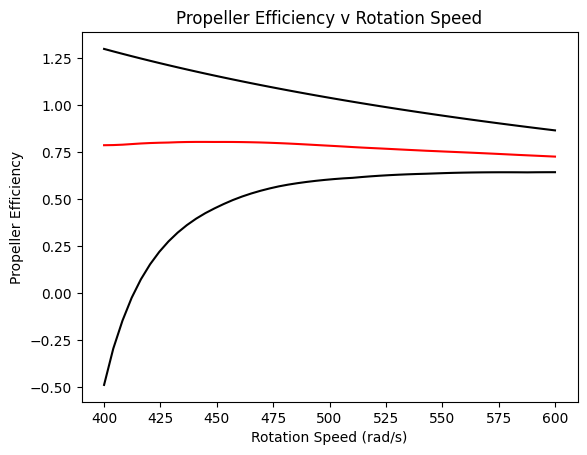

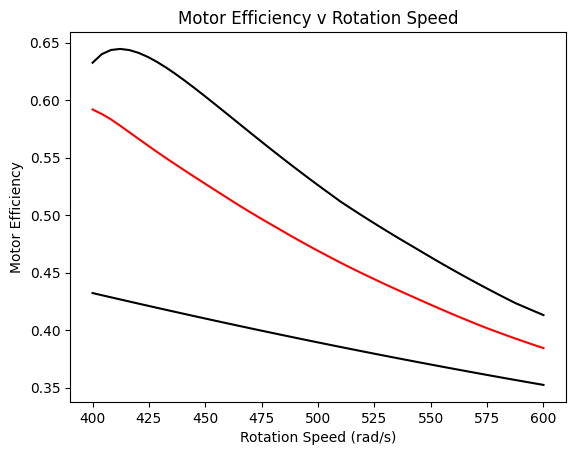

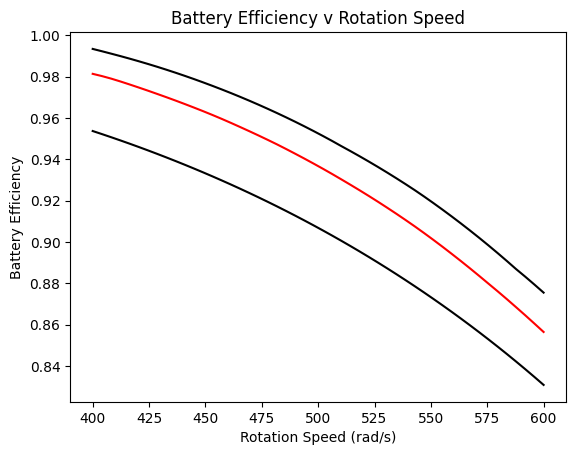

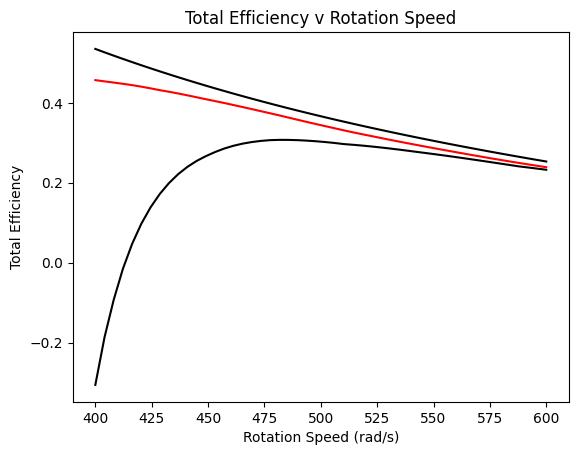

In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

import numpy as np
import sympy as sy
import pandas as pd
from matplotlib import pyplot as plt

flight_speed = 15 #m/s
battery_ocv = 22.2 #volts
battery_capacity = 5 #amp hours
battery_resistance = 0.6 #ohms
propeller_diameter = 0.254 #meters
air_density = 1.225 #kg/m^3
motor_kv = 800 * (2 * np.pi / 60) #rpm/v
motor_resistance = 1.2 #ohms
motor_I0 = 0.2 #amps
dat_3002 = pd.read_csv('dat_3002.txt', delim_whitespace=True)
dat_4002 = pd.read_csv('dat_4002.txt', delim_whitespace=True)
dat_4003 = pd.read_csv('dat_4002.txt', delim_whitespace=True)
dat_5008 = pd.read_csv('dat_5008.txt', delim_whitespace=True)
dat_5026 = pd.read_csv('dat_5026.txt', delim_whitespace=True)
dat_5998 = pd.read_csv('dat_5998.txt', delim_whitespace=True)
dat_6009 = pd.read_csv('dat_6009.txt', delim_whitespace=True)

#from chatgpt
def interpolate_ct_cp(df, target_value):
    # Get the minimum and maximum values in 'J'
    min_J = df['J'].min()
    max_J = df['J'].max()

    # Check if the target value is outside the bounds
    if target_value <= min_J:
        return df.loc[df['J'].idxmin(), ['CT', 'CP']]
    elif target_value >= max_J:
        return df.loc[df['J'].idxmax(), ['CT', 'CP']]

    # Find the two closest indices
    closest_indices = df['J'].sub(target_value).abs().nsmallest(2).index

    # Get the values for interpolation
    J1, J2 = df.loc[closest_indices, 'J']
    CT1, CT2 = df.loc[closest_indices, 'CT']
    CP1, CP2 = df.loc[closest_indices, 'CP']

    # Perform linear interpolation
    weight = (target_value - J1) / (J2 - J1)
    interpolated_CT = CT1 + weight * (CT2 - CT1)
    interpolated_CP = CP1 + weight * (CP2 - CP1)

    return interpolated_CT, interpolated_CP

#propeller calculations
# rotation_speed = 400
rotation_speed = np.linspace(400,600,50)
propeller_efficiency_range = np.zeros((3,len(rotation_speed)))
motor_current_range = np.zeros((3,1))
motor_vs_range = np.zeros((3,len(rotation_speed)))
motor_efficiency_range = np.zeros((3,len(rotation_speed)))
motor_power_range = np.zeros((3,len(rotation_speed)))
battery_current_range = np.zeros((3,len(rotation_speed)))
battery_efficiency_range = np.zeros((3,len(rotation_speed)))
for j in range(0,len(rotation_speed)):
    n = rotation_speed[j] / (2 * np.pi)
    J = flight_speed / (n * propeller_diameter)

    interpolated_CT_3002, interpolated_CP_3002 = interpolate_ct_cp(dat_3002, J)
    interpolated_CT_4002, interpolated_CP_4002 = interpolate_ct_cp(dat_4002, J)
    interpolated_CT_4003, interpolated_CP_4003 = interpolate_ct_cp(dat_4003, J)
    interpolated_CT_5008, interpolated_CP_5008 = interpolate_ct_cp(dat_5008, J)
    interpolated_CT_5026, interpolated_CP_5026 = interpolate_ct_cp(dat_5026, J)
    interpolated_CT_5998, interpolated_CP_5998 = interpolate_ct_cp(dat_5998, J)
    interpolated_CT_6009, interpolated_CP_6009 = interpolate_ct_cp(dat_6009, J)

    possible_CT = np.array([interpolated_CT_3002, interpolated_CT_4002, interpolated_CT_4003, interpolated_CT_5008, interpolated_CT_5026, interpolated_CT_5998, interpolated_CT_6009])
    possible_CP = np.array([interpolated_CP_3002, interpolated_CP_4002, interpolated_CP_4003, interpolated_CP_5008, interpolated_CP_5026, interpolated_CP_5998, interpolated_CP_6009])
    possible_CQ = possible_CP / (2 * np.pi)

    possible_T = possible_CT * air_density * n**2 * propeller_diameter**4
    possible_P = possible_CP * air_density * n**3 * propeller_diameter**5
    possible_Q = possible_CQ * air_density * n**2 * propeller_diameter**5

    possible_T_range = np.array([np.min(possible_T), np.mean(possible_T), np.max(possible_T)])
    possible_P_range = np.array([np.min(possible_P), np.mean(possible_P), np.max(possible_P)])
    possible_Q_range = np.array([np.min(possible_Q), np.mean(possible_Q), np.max(possible_Q)])

    for i in range(0,3):
        propeller_efficiency_range[i,j] = possible_T_range[i] * flight_speed / (possible_Q_range[i] * (rotation_speed[j]))

        #motor calculations
        motor_current_range[i] = possible_Q_range[i] * motor_kv + motor_I0
        motor_vs_range[i,j] = motor_current_range[i] * motor_resistance + (rotation_speed[j] / motor_kv)
        motor_power_range[i,j] = possible_Q_range[i] * rotation_speed[j]
        motor_efficiency_range[i,j] = possible_Q_range[i] * rotation_speed[j] / (motor_current_range[i] * motor_vs_range[i,j])

        #battery calculations
        battery_current_range[i,j] = (battery_ocv / (2 * battery_resistance)) - np.sqrt((battery_ocv / (2 * battery_resistance))**2 - (motor_power_range[i,j] / battery_resistance))
        battery_efficiency_range[i,j] = 1 - (battery_current_range[i,j] / battery_ocv)

plt.figure()
plt.plot(rotation_speed, propeller_efficiency_range[0,:],'black')
plt.plot(rotation_speed, propeller_efficiency_range[1,:],'red')
plt.plot(rotation_speed, propeller_efficiency_range[2,:],'black')
plt.xlabel('Rotation Speed (rad/s)')
plt.ylabel('Propeller Efficiency')
plt.title('Propeller Efficiency v Rotation Speed')
plt.show()

plt.figure()
plt.plot(rotation_speed, motor_efficiency_range[0,:],'black')
plt.plot(rotation_speed, motor_efficiency_range[1,:],'red')
plt.plot(rotation_speed, motor_efficiency_range[2,:],'black')
plt.xlabel('Rotation Speed (rad/s)')
plt.ylabel('Motor Efficiency')
plt.title('Motor Efficiency v Rotation Speed')
plt.show()

plt.figure()
plt.plot(rotation_speed, battery_efficiency_range[0,:],'black')
plt.plot(rotation_speed, battery_efficiency_range[1,:],'red')
plt.plot(rotation_speed, battery_efficiency_range[2,:],'black')
plt.xlabel('Rotation Speed (rad/s)')
plt.ylabel('Battery Efficiency')
plt.title('Battery Efficiency v Rotation Speed')
plt.show()

plt.figure()
plt.plot(rotation_speed, battery_efficiency_range[0,:] * motor_efficiency_range[0,:] * propeller_efficiency_range[0,:],'black')
plt.plot(rotation_speed, battery_efficiency_range[1,:] * motor_efficiency_range[1,:] * propeller_efficiency_range[1,:],'red')
plt.plot(rotation_speed, battery_efficiency_range[2,:] * motor_efficiency_range[2,:] * propeller_efficiency_range[2,:],'black')
plt.xlabel('Rotation Speed (rad/s)')
plt.ylabel('Total Efficiency')
plt.title('Total Efficiency v Rotation Speed')
plt.show()